In [1]:
import os
import sys

sys.path.append(os.path.abspath("../../"))

%matplotlib inline
import matplotlib.pyplot as plt
import my_utils as utils
import numpy as np
import pandas as pd

BASE_PATH_CONCAT = os.path.join("results", "early_concat")
BASE_PATH_FUSION = os.path.join("results", "late_fusion")

## IEMOCAP



In [2]:
DATASET = "IEMOCAP"


def get_result_dataframe(dataset: str) -> pd.DataFrame:
    fusion_path = os.path.join(BASE_PATH_FUSION, dataset, "preds_test.json")
    fusion_audio_path = os.path.join(
        BASE_PATH_FUSION, dataset, "preds_test_no_text.json"
    )
    concat_path = os.path.join(BASE_PATH_CONCAT, dataset, "preds_test_normal.json")
    concat_audio_path = os.path.join(
        BASE_PATH_CONCAT, dataset, "preds_test_audio_only.json"
    )

    fusion_df = utils.build_result_dataframe(fusion_path)
    fusion_audio_df = utils.build_result_dataframe(fusion_audio_path)
    concat_df = utils.build_result_dataframe(concat_path)
    concat_audio_df = utils.build_result_dataframe(concat_audio_path)

    assert len(fusion_df) == len(concat_df)

    results = utils.merge_result_dataframes(
        [fusion_df, concat_df, fusion_audio_df, concat_audio_df],
        ["fusion", "concat", "fusion_audio", "concat_audio"],
    )
    results = utils.extract_dialogue_information(results)

    return results


df = get_result_dataframe(DATASET)
df.head(3)

,input,output,target,certainty,gate,input_concat,output_concat,input_fusion_audio,output_fusion_audio,certainty_fusion_audio,input_concat_audio,output_concat_audio,utterance,dialogue_length,utterence_length
index,,,,,,,,,,,,,,,
0,Now you are expert of sentiment and emotional ...,neutral,neutral,0.532227,"[0.389404296875, 0.0396728515625]",Now you are expert of sentiment and emotional ...,neutral,Now you are expert of sentiment and emotional ...,neutral,0.571289,Now you are expert of sentiment and emotional ...,neutral,"Hi, I need an ID.",1,5
1,Now you are expert of sentiment and emotional ...,neutral,neutral,0.719727,"[0.31298828125, 0.13037109375]",Now you are expert of sentiment and emotional ...,neutral,Now you are expert of sentiment and emotional ...,neutral,0.518066,Now you are expert of sentiment and emotional ...,excited,"ahh Yeah, this is the wrong line. I'm sorry. ...",2,26
2,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.773926,"[0.74365234375, 0.0360107421875]",Now you are expert of sentiment and emotional ...,frustrated,Now you are expert of sentiment and emotional ...,neutral,0.437012,Now you are expert of sentiment and emotional ...,frustrated,"Okay, I'm sorry, but I just stood in this line...",3,21


In [3]:
labels = df["target"].value_counts().index.to_list()
labels

['neutral', 'frustrated', 'excited', 'sad', 'angry', 'happy']

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/sentiment_iemocap_cm.png


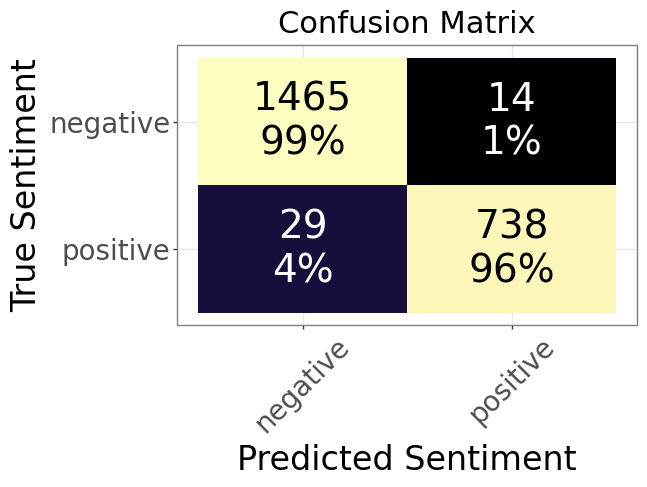

In [4]:
from functools import partial


iemocap_positive_emotions = ["happy", "excited"]
iemocap_negative_emotions = ["angry", "sad", "frustrated"]


iemocap_classify_sentiment = partial(
    utils.classify_sentiment,
    positive=iemocap_positive_emotions,
    negative=iemocap_negative_emotions,
)

df["emotion_sentiment"] = df["target"].apply(iemocap_classify_sentiment)
df_long = df.melt(
    id_vars=["emotion_sentiment", "target", "utterance"],
    value_vars=["output", "output_concat"],
    var_name="source",
    value_name="output_long",
)
df_long["emotion_sentiment_prediction"] = df_long["output_long"].apply(
    iemocap_classify_sentiment
)


utils.print_confusion_matrix(
    df_long,
    target_labels=["positive", "negative"],
    output_column="emotion_sentiment_prediction",
    target_column="emotion_sentiment",
    xlab_name="Predicted Sentiment",
    ylab_name="True Sentiment",
    text_size=28,
    label_scaling_adjustment=4,
    name="images/sentiment_iemocap_cm.png",
)

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/negative_iemocap_cm.png


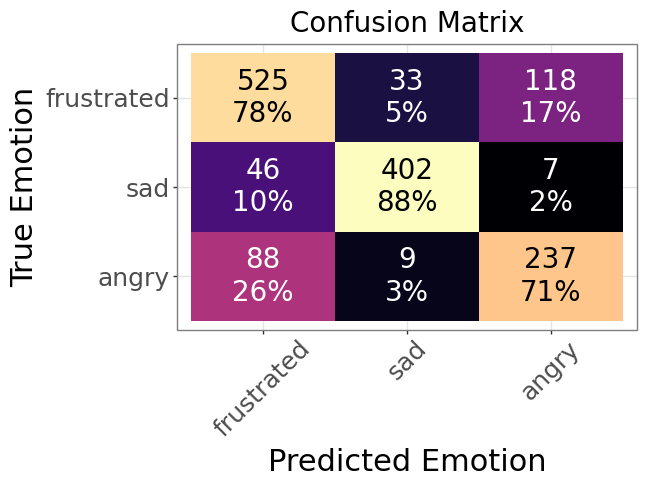

In [5]:
utils.print_confusion_matrix(
    df_long,
    target_labels=iemocap_negative_emotions,
    output_column="output_long",
    target_column="target",
    text_size=20,
    label_scaling_adjustment=2,
    name="images/negative_iemocap_cm.png",
)

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/positive_iemocap_cm.png


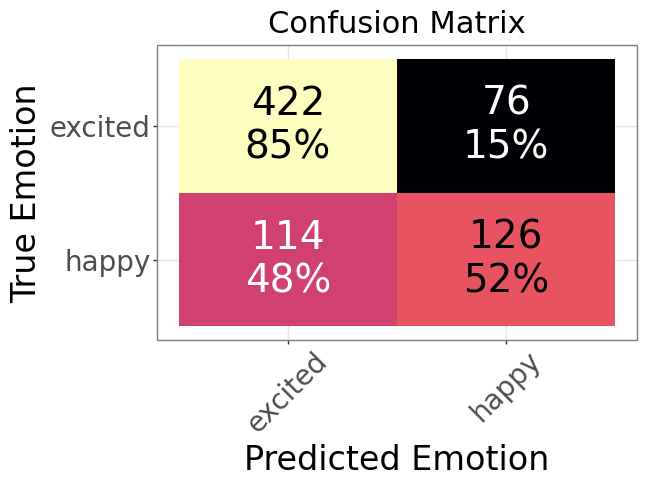

In [6]:
utils.print_confusion_matrix(
    df_long,
    target_labels=iemocap_positive_emotions,
    output_column="output_long",
    target_column="target",
    text_size=28,
    label_scaling_adjustment=4,
    name="images/positive_iemocap_cm.png",
)

## Audio

In [7]:
df_long_audio = df.melt(
    id_vars=["emotion_sentiment", "target", "utterance"],
    value_vars=["output_fusion_audio", "output_concat_audio"],
    var_name="source",
    value_name="output_long",
)
df_long_audio

,emotion_sentiment,target,utterance,source,output_long
0,neutral,neutral,"Hi, I need an ID.",output_fusion_audio,neutral
1,neutral,neutral,"ahh Yeah, this is the wrong line. I'm sorry. ...",output_fusion_audio,neutral
2,negative,frustrated,"Okay, I'm sorry, but I just stood in this line...",output_fusion_audio,neutral
3,negative,frustrated,"No, they told me-I'm sorry, but they told me t...",output_fusion_audio,neutral
4,negative,frustrated,"What, I mean what... what's the difference? W...",output_fusion_audio,neutral
...,...,...,...,...,...
3239,negative,angry,oh! Marry you again? I wouldn't marry you agai...,output_concat_audio,angry
3240,negative,angry,Beast,output_concat_audio,angry
3241,negative,angry,You're a wicked little vampire. And I pray to...,output_concat_audio,angry
3242,negative,angry,Brute,output_concat_audio,angry


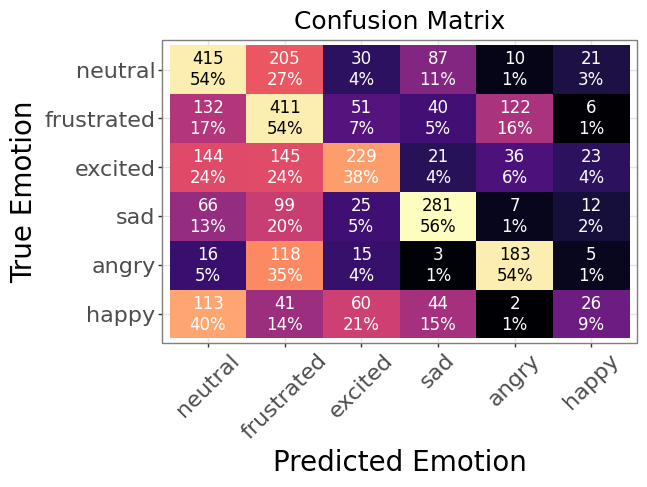

In [8]:
utils.print_confusion_matrix(
    df_long_audio,
    target_labels=labels[::-1],
    output_column="output_long",
    target_column="target",
)

In [33]:
fusion_model = df["target"] == df["output"] 
concat_model = df["target"] == df["output_concat"]  

In [39]:
from sklearn.metrics import f1_score

df["any_correct"] = df["target"]
df.loc[~fusion_model & ~concat_model, "any_correct"] = df[~fusion_model & ~concat_model]["output"]
f1_score(df["target"], df["any_correct"], labels=labels, average="weighted")


0.7895530234085267

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/discussion_iemocap_diff_cm.png


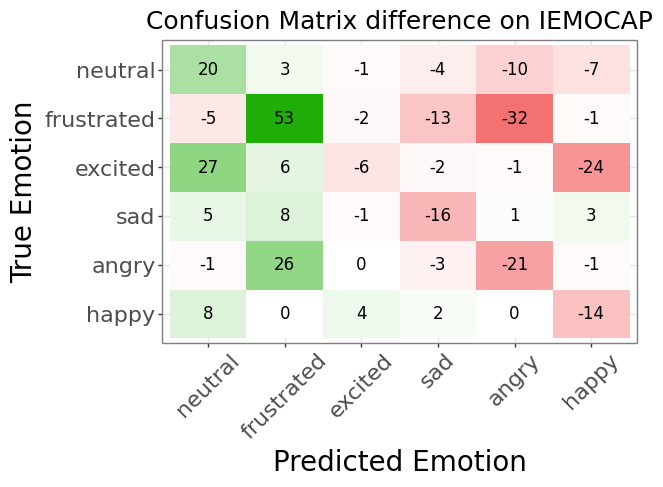

In [10]:
utils.print_confusion_matrix_difference(df, target_labels=labels[::-1], output_column1="output", output_column2="output_concat", name = "images/discussion_iemocap_diff_cm.png", title="Confusion Matrix difference on IEMOCAP")

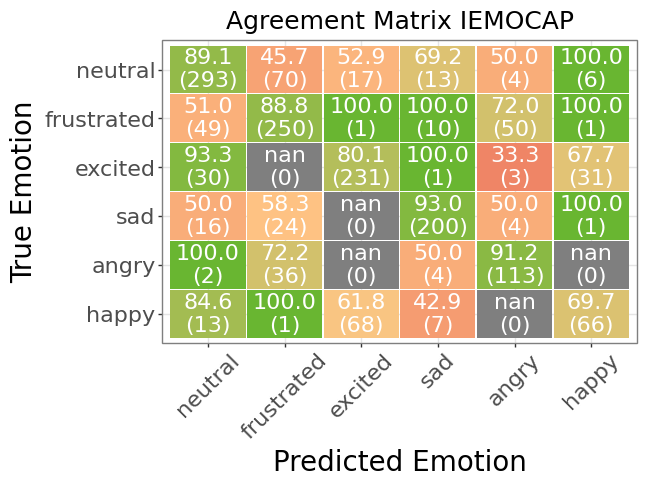

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/discussion_iemocap_agreement.png


In [28]:
from plotnine import *


def iou(df, label_true, label_pred=None):
    label_pred = label_pred if label_pred is not None else label_true
    diff = len(df[(df["target"] == label_true) & (df["output"] == label_pred)]) - len(
        df[(df["target"] == label_true) & (df["output_concat"] == label_pred)]
    )
    inter = df[
        (df["target"] == label_true) & (df["output"] == label_pred)
    ].index.intersection(
        df[(df["target"] == label_true) & (df["output_concat"] == label_pred)].index
    )
    union = df[(df["target"] == label_true) & (df["output"] == label_pred)].index.union(
        df[(df["target"] == label_true) & (df["output_concat"] == label_pred)].index
    )

    numerator = len(inter)
    denominator = len(union)
    denominator_norm = len(union) - abs(diff)
    result_iou = numerator / denominator if denominator != 0 else np.nan
    result_norm = numerator / denominator_norm if denominator_norm != 0 else np.nan
    return {"iou": result_iou, "agreement": result_norm, "denominator": denominator_norm, "numerator": numerator}


cm_iou, cm_agreement = [], []
for label_true in labels:
    preds_iou, preds_agreement = [], []
    for label_pred in labels:
        r = iou(df, label_true, label_pred)
        preds_iou.append(r["denominator"])
        preds_agreement.append(r["agreement"])
    cm_iou.append(preds_iou)
    cm_agreement.append(preds_agreement)


melted_iou = utils._prepare_confusion_matrix(cm_iou, labels).merge(
    utils._prepare_confusion_matrix(cm_agreement, labels),
    on=["actual", "predicted"],
    suffixes=["_iou", "_agreement"],
)
melted_iou["label"] = (
    (melted_iou["count_agreement"] * 100).round(1).astype(str)
    + "\n("
    + (melted_iou["count_iou"]).round(1).astype(str) + ")"
)
melted_iou

p = (
    ggplot(melted_iou, aes("factor(predicted)", "factor(actual)", fill="count_agreement * 100"))
    + geom_tile(show_legend=True, width=0.98, height=0.98)
    + geom_text(aes(label="label"), size=16, show_legend=False, color = "white")
    + ggtitle("Agreement Matrix IEMOCAP")
    + ylab("True Emotion")
    + xlab("Predicted Emotion")
    + scale_y_discrete(limits=labels[::-1])
    + scale_fill_gradient2(low="#DC3440", mid = "#FFC685", high="#1fae08", limits=[0, 100], midpoint=60)
    + theme_bw()
    + guides(fill="none")
    + theme(
        title=element_text(size=18),  # Increases title size
        axis_title=element_text(
            size=20
        ),  # Increases axis title size
        axis_text=element_text(
            size=16
        ),  # Increases axis tick label size
        axis_text_x=element_text(rotation=45),  # Rotates x-axis tick labels
    )
)
p.show()
p.save("images/discussion_iemocap_agreement.png", width=7, height=7, dpi=300)

In [12]:
iou(df, "frustrated", "neutral")

{'iou': 0.46296296296296297, 'agreement': 0.5102040816326531}

In [13]:
concat_model = df["target"] == df["output_concat"]
fusion_model = df["target"] == df["output"]

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/discussion_iemocap_false_prediction_agreement.png


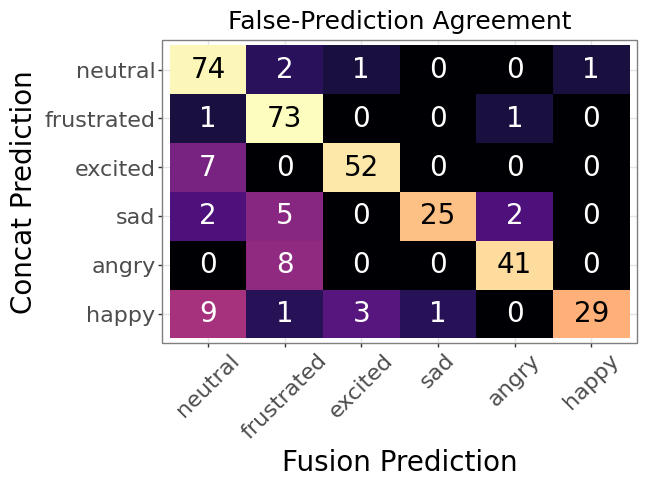

In [25]:
utils.print_confusion_matrix(
    df[~concat_model & ~fusion_model],
    target_labels=labels[::-1],
    output_column="output",
    target_column="output_concat",
    xlab_name="Fusion Prediction",
    ylab_name="Concat Prediction",
    title="False-Prediction Agreement",
    show_percentage=False,
    name="images/discussion_iemocap_false_prediction_agreement.png",
    text_size=20
)

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

for label in labels:
    y_true = df["target"].apply(lambda x: 1 if x == label else 0)
    y_pred_fusion = df["output"].apply(lambda x: 1 if x == label else 0)
    y_pred_concat = df["output_concat"].apply(lambda x: 1 if x == label else 0)

    pre_label = precision_score(y_true, y_pred_fusion) * 100
    rec_label = recall_score(y_true, y_pred_fusion) * 100
    pre_label_ierc = precision_score(y_true, y_pred_concat) * 100
    rec_label_ierc = recall_score(y_true, y_pred_concat) * 100
    f1_fusion = f1_score(y_true, y_pred_fusion) * 100
    f1_concat = f1_score(y_true, y_pred_concat) * 100
    
    print(f"F1-score\t für Label {label}: Fusion: {f1_fusion:.2f} - Concat: {f1_concat:.2f} - Different: {(f1_fusion - f1_concat):.2f}")
    print(f"Precision\t für Label {label}: Fusion: {pre_label:.2f} - Concat: {pre_label_ierc:.2f} - Differenz: {(pre_label - pre_label_ierc):.2f}")
    print(f"Recall\t\t für Label {label}: Fusion: {rec_label:.2f} - Concat: {rec_label_ierc:.2f} - Differenz: {(rec_label - rec_label_ierc):.2f}")
    print()

F1-score	 für Label neutral: Fusion: 73.06 - Concat: 72.99 - Different: 0.07
Precision	 für Label neutral: Fusion: 69.23 - Concat: 73.87 - Differenz: -4.64
Recall		 für Label neutral: Fusion: 77.34 - Concat: 72.14 - Differenz: 5.21

F1-score	 für Label frustrated: Fusion: 70.92 - Concat: 65.65 - Different: 5.27
Precision	 für Label frustrated: Fusion: 66.59 - Concat: 69.82 - Differenz: -3.23
Recall		 für Label frustrated: Fusion: 75.85 - Concat: 61.94 - Differenz: 13.91

F1-score	 für Label excited: Fusion: 71.72 - Concat: 73.04 - Different: -1.31
Precision	 für Label excited: Fusion: 74.02 - Concat: 74.56 - Differenz: -0.54
Recall		 für Label excited: Fusion: 69.57 - Concat: 71.57 - Differenz: -2.01

F1-score	 für Label sad: Fusion: 82.13 - Concat: 82.61 - Different: -0.48
Precision	 für Label sad: Fusion: 85.78 - Concat: 80.08 - Differenz: 5.70
Recall		 für Label sad: Fusion: 78.78 - Concat: 85.31 - Differenz: -6.53

F1-score	 für Label angry: Fusion: 65.45 - Concat: 65.65 - Differen

### Weitere Statistiken
Hier werden weitere Statistiken genannt, wie das Klassifizierungsverhalten der einzelnen Teilmodelle ist.
Es wurden einmal die Ergebnisse von InstructERC, dem Late-Fusion Modell audio output, und dem kombinierten Modell berechnet


In [13]:
# 2. late-fusion Model (F)
df_F = df[fusion_model]
print(f"In total, {len(df_F)} samples were recognized by the late-fusion model.")

# 3. concat Model (C)
df_C = df[concat_model]
print(f"In total, {len(df_C)} samples were recognized by the concat model.")


# 5. NOT late-fusion Model (¬F)
df_not_F = df[not_fusion_model]
print(f"In total, {len(df_not_F)} samples were NOT recognized by the late-fusion model.")

# 6. NOT concat Model (¬C)
df_not_C = df[not_concat_model]
print(f"In total, {len(df_not_C)} samples were NOT recognized by the concat model.")


# 9. late-fusion AND concat Models (F ∧ C)
df_F_and_C = df[fusion_model & concat_model]
print(f"In total, {len(df_F_and_C)} samples were recognized by both the late-fusion and concat models.")


# 13. late-fusion AND NOT concat Models (F ∧ ¬C)
df_F_and_not_C = df[fusion_model & not_concat_model]
print(f"In total, {len(df_F_and_not_C)} samples were recognized by the late-fusion model but NOT by the concat model.")


# 15. concat AND NOT late-fusion Models (C ∧ ¬F)
df_C_and_not_F = df[concat_model & not_fusion_model]
print(f"In total, {len(df_C_and_not_F)} samples were recognized by the concat model but NOT by the late-fusion model.")


# 18. NOT late-fusion AND NOT concat Models (¬F ∧ ¬C)
df_not_F_and_not_C = df[not_fusion_model & not_concat_model]
print(f"In total, {len(df_not_F_and_not_C)} samples were NOT recognized by both the late-fusion and concat models.")


In total, 1151 samples were recognized by the late-fusion model.
In total, 1135 samples were recognized by the concat model.
In total, 471 samples were NOT recognized by the late-fusion model.
In total, 487 samples were NOT recognized by the concat model.
In total, 1003 samples were recognized by both the late-fusion and concat models.
In total, 148 samples were recognized by the late-fusion model but NOT by the concat model.
In total, 132 samples were recognized by the concat model but NOT by the late-fusion model.
In total, 339 samples were NOT recognized by both the late-fusion and concat models.
